<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/SAMed_Endo_Original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
https://drive.google.com/file/d/157Q_e4oR4b-Wo4lywUIvQSHnNb7LFgR5/view?usp=sharing

# Testing Urvi's Endonasal DataLoader

17:33, Sep 27 - Resolved without actually having to test the dataloader since it was an issue with having a learning rate that is too high.

In [1]:
!gdown 157Q_e4oR4b-Wo4lywUIvQSHnNb7LFgR5

Downloading...
From (original): https://drive.google.com/uc?id=157Q_e4oR4b-Wo4lywUIvQSHnNb7LFgR5
From (redirected): https://drive.google.com/uc?id=157Q_e4oR4b-Wo4lywUIvQSHnNb7LFgR5&confirm=t&uuid=fa1f8f20-71e2-4154-8129-6675507bec33
To: /content/Endonasal_Slices_All.zip
100% 914M/914M [00:37<00:00, 24.4MB/s]


In [2]:
!unzip -q Endonasal_Slices_All.zip

In [3]:
!pip3 -q install tqdm imageio[pyav] imageio-ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 32.8 MB/s eta 0:00:00


In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import imageio as iio
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from scipy.ndimage import zoom
from einops import repeat
from scipy import ndimage
import random
from PIL import Image
import cv2

def normalise_intensity(image, ROI_thres=0.1):
    pixel_thres = np.percentile(image, ROI_thres)
    ROI = np.where(image > pixel_thres, image, 0) # If image value is greater than pixel threshold, return image value, otherwise return 0
    mean = np.mean(ROI)
    std = np.std(ROI)
    ROI_norm = (ROI - mean) / (std + 1e-8) # Normalise ROI
    return ROI_norm

def random_rot_flip(image, label):
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    label = np.rot90(label, k)
    axis = np.random.randint(0, 2)
    image = np.flip(image, axis=axis).copy()
    label = np.flip(label, axis=axis).copy()
    return image, label


def random_rotate(image, label):
    angle = np.random.randint(-20, 20)
    image = ndimage.rotate(image, angle, order=0, reshape=False)
    label = ndimage.rotate(label, angle, order=0, reshape=False)
    return image, label

def map_labels(label):
    label_map = {0: 0, 85: 1, 128: 1, 170: 2, 255: 2}
    mapped_label = label.copy()
    for k, v in label_map.items():
        mapped_label[label == k] = v
    return mapped_label

class RandomGenerator(object):
    def __init__(self, output_size, low_res):
        self.output_size = output_size
        self.low_res = low_res

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if random.random() > 0.5:
            image, label = random_rot_flip(image, label)
        elif random.random() > 0.5:
            image, label = random_rotate(image, label)
        x, y = image.shape
        if x != self.output_size[0] or y != self.output_size[1]:
            image = zoom(image, (self.output_size[0] / x, self.output_size[1] / y), order=3)  # why not 3?
            label = zoom(label, (self.output_size[0] / x, self.output_size[1] / y), order=0)
        label_h, label_w = label.shape
        low_res_label = zoom(label, (self.low_res[0] / label_h, self.low_res[1] / label_w), order=0)
        image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0)
        image = repeat(image, 'c h w -> (repeat c) h w', repeat=3)
        label = torch.from_numpy(label.astype(np.float32))
        low_res_label = torch.from_numpy(low_res_label.astype(np.float32))
        sample = {'image': image, 'label': label.long(), 'low_res_label': low_res_label.long()}
        return sample

class EndonasalDataset(Dataset):
    def __init__(self, root='endonasal_train', low_res=None, isTrain=False):
        self.img_path_all = glob(root + '/mri_t1c/*.png')  # Update the path and pattern
        print(self.img_path_all)
        self.mask_path_all = [img_path.replace('mri_t1c', 'mri_masks') for img_path in self.img_path_all]
        self.isTrain = isTrain
        self.low_res = low_res

    def __len__(self):
      return len(self.img_path_all)

    def __getitem__(self, index):
        if not os.path.exists(self.img_path_all[index]):
            raise ValueError(f"Image file not found: {self.img_path_all[index]}")

        image = iio.imread(self.img_path_all[index])

        # Add a check to handle potential errors during image reading
        if image is None:
            raise ValueError(f"Failed to read image: {self.img_path_all[index]}")

        image = normalise_intensity(image)
        image = zoom(image, (512/image.shape[0], 512/image.shape[1]), order=0)

        # Check if the mask file exists
        if not os.path.exists(self.mask_path_all[index]):
            raise ValueError(f"Mask file not found: {self.mask_path_all[index]}")

        label = iio.imread(self.mask_path_all[index])

        if label is None:
            raise ValueError(f"Failed to read mask: {self.mask_path_all[index]}")

        label = zoom(label, (512/label.shape[0], 512/label.shape[1]), order=0)

        if self.isTrain:
            if random.random() > 0.5:
                image, label = random_rot_flip(image, label)
            elif random.random() > 0.5:
                image, label = random_rotate(image, label)

        image = repeat(np.expand_dims(image, axis=0), 'c h w -> (repeat c) h w', repeat=3)
        image = torch.from_numpy(image).float() # Converting double to single precision float
        sample = {'image': image, 'label': label}
        if self.low_res:
            low_res_label = zoom(label, (self.low_res/label.shape[0], self.low_res/label.shape[1]), order=0)
            sample = {'image': image, 'label': label, 'low_res_label': low_res_label}

        return sample

In [ ]:
# label = iio.imread(self.mask_path_all[index])


In [12]:
seed = 1234
batch_size = 10
# Need to change the name of the Endonasal_Slices folder after gdowning
db_train = EndonasalDataset(root='/content/Endonasal_Slices_All/Train', low_res=128, isTrain=True)
db_test = EndonasalDataset(root='/content/Endonasal_Slices_All/Test', low_res=128)
print('Train Sample:', len(db_train), 'Test Sample:', len(db_test))


def worker_init_fn(worker_id):
        random.seed(seed + worker_id)

trainloader = DataLoader(db_train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True,
                             worker_init_fn=worker_init_fn)
validloader = DataLoader(db_test, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True,
                             worker_init_fn=worker_init_fn)

['/content/Endonasal_Slices_All/Train/mri_t1c/mri0164_slice265_cor.png', '/content/Endonasal_Slices_All/Train/mri_t1c/mri0066_slice459_sag.png', '/content/Endonasal_Slices_All/Train/mri_t1c/mri0164_slice462_cor.png', '/content/Endonasal_Slices_All/Train/mri_t1c/mri0164_slice235_sag.png', '/content/Endonasal_Slices_All/Train/mri_t1c/mri0152_slice285_cor.png', '/content/Endonasal_Slices_All/Train/mri_t1c/mri0152_slice297_cor.png', '/content/Endonasal_Slices_All/Train/mri_t1c/mri0167_slice10_sag.png', '/content/Endonasal_Slices_All/Train/mri_t1c/mri0151_slice77_sag.png', '/content/Endonasal_Slices_All/Train/mri_t1c/mri0164_slice200_cor.png', '/content/Endonasal_Slices_All/Train/mri_t1c/mri0066_slice330_cor.png', '/content/Endonasal_Slices_All/Train/mri_t1c/mri0164_slice243_sag.png', '/content/Endonasal_Slices_All/Train/mri_t1c/mri0155_slice160_cor.png', '/content/Endonasal_Slices_All/Train/mri_t1c/mri0066_slice315_sag.png', '/content/Endonasal_Slices_All/Train/mri_t1c/mri0152_slice96_sag.

<ipython-input-4-3ad826c23a3f>:87: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = iio.imread(self.img_path_all[index])
<ipython-input-4-3ad826c23a3f>:100: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = iio.imread(self.mask_path_all[index])


tensor([0, 1, 2], dtype=torch.uint8)


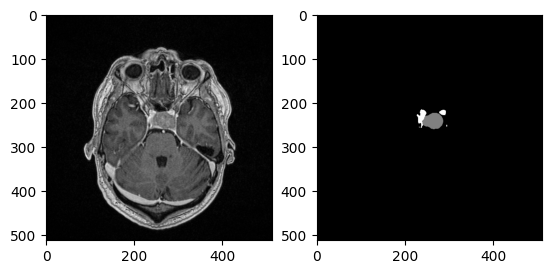

In [33]:
import matplotlib.pyplot as plt
idx = 0
for sample_b in validloader:
    # print(sample_b['image'][idx].shape, sample_b['label'][idx].shape)
    print(sample_b['label'][idx].unique())
    break

plt.subplot(121); plt.imshow(sample_b['image'][idx][0], cmap='gray')
plt.subplot(122); plt.imshow(sample_b['label'][idx], cmap='gray')

In [6]:
from tqdm import tqdm
import imageio.v2 as imageio
max_epoch = 80
iterator = tqdm(range(max_epoch), ncols=70)
for epoch_num in iterator:
  for i_batch, sampled_batch in enumerate(trainloader):
      image_batch, label_batch = sampled_batch['image'], sampled_batch['label']  # [b, c, h, w], [b, h, w]
      low_res_label_batch = sampled_batch['low_res_label']
      image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
      low_res_label_batch = low_res_label_batch.cuda()
      # Do we need this assertion for the endonasal dataset? Not sure, prolly not
      # assert image_batch.max() <= 3, f'image_batch max: {image_batch.max()}'
      iter_num = iter_num + 1
      print(f'Epoch: {epoch_num}, Iteration: {iter_num}, image_batch shape: {image_batch.shape}, label_batch shape: {label_batch.shape}, low_res_label_batch shape: {low_res_label_batch.shape}')

        # For debugging logging.info(f'loss dice {type(loss_dice)} and dice_loss type is: {type(dice_loss)}')


      for i_batch, sampled_batch in enumerate(validloader):
          image_batch, label_batch = sampled_batch['image'], sampled_batch['label']  # [b, c, h, w], [b, h, w]
          low_res_label_batch = sampled_batch['low_res_label']
          image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
          low_res_label_batch = low_res_label_batch.cuda()
          # Do I need this assertion?
          # assert image_batch.max() <= 3, f'image_batch max: {image_batch.max()}'
          print(f'Epoch: {epoch_num}, Iteration: {iter_num}, image_batch shape: {image_batch.shape}, label_batch shape: {label_batch.shape}, low_res_label_batch shape: {low_res_label_batch.shape}')


  0%|                                          | 0/80 [00:00<?, ?it/s]<ipython-input-4-3ad826c23a3f>:87: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = iio.imread(self.img_path_all[index])
<ipython-input-4-3ad826c23a3f>:100: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = iio.imread(self.mask_path_all[index])
<ipython-input-4-3ad826c23a3f>:87: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx